In [173]:
import numpy as np
import seaborn as sb
import pandas
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_boston
from sklearn.linear_model import LinearRegression, RidgeClassifier, LogisticRegression, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
%matplotlib notebook

# Linear Classification

Let's first repurpose our regression model to do classification. For this, we will train two classifiers with different label distributions on the training data. We then run both classifiers on the test data, and the one with the higher output "wins".

In [ ]:
# get iris data and only select the first two iris species
iris = load_iris()
X = iris.data[0:100]
y = iris.target[0:100]

# normalize
X = (X-X.mean(axis=0))/X.std(axis=0)

# train first classifier
lr1 = LinearRegression()
lr1.fit(X,y)

# train second classifier on inverse labels
lr2 = LinearRegression()
lr2.fit(X,1-y)

# plot the classifier outputs and the true labels
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(lr1.predict(X),label='classifier 1')
plt.plot(lr2.predict(X),label='classifier 2')
plt.plot(y,label='true label')
plt.legend(loc='best')
plt.title('{:.3f}% recognition accuracy'.format(np.size(np.where(((lr1.predict(X)>lr2.predict(X))-y)==0))))
plt.show()


As we can see, this works pretty well. Of course, as you know by now, we made a big mistake here:

** We did not do cross validation!** 

Our results are therefore most likely "overfit". Let's remedy this:

In [ ]:
# get iris data and only select the second two iris species
# we know that these are a bit harder to separate!
iris = load_iris()
X = iris.data[50:]
# change the labels from "1","2" to "0","1"
y = iris.target[50:]-1

# normalize
X = (X-X.mean(axis=0))/X.std(axis=0)

# make cross validation splits, taking care to choose the same
# amount of classes in each split!
CV = StratifiedKFold(n_splits=8)

# make a list of accuracy values to be populated 
acc = list()

# init two classifiers
lr1 = LinearRegression()
lr2 = LinearRegression()

# this loops across all splits for the data
for train, test in CV.split(X, y):
    
    # fit the two classifiers
    lr1.fit(X[train],y[train])
    lr2.fit(X[train],1-y[train])
    
    # check the accuracy on the test data
    acc.append(np.size(np.where(((lr1.predict(X[test])>lr2.predict(X[test]))-y[test])==0))/len(test))

print('found mean accuracy of {:.3f}'.format(np.mean(acc)))
print(acc)

As we see, not all splits are able to generate this good performance. Hence, our estimate of 100% accuracy is definitely over-optimistic!!

# Logistic regression

Here, we will use the `sklearn` implementation for logistic regression (which is a classification algorithm). The implementation is a lot more powerful than we discussed in class, but for now we will force it to do the standard model.

In [ ]:
acc = list()

# init logistic regression - note that the default logistic
# regression in sklearn has a regularizer built in on the weights
# if we specify a very large "C" value, we switch this OFF and
# obtain the "standard" logistic regression model!
logit = LogisticRegression(C=1000000)

# this loops across all splits for the data
for train, test in CV.split(X, y): 
    # fit the classifier
    logit.fit(X[train],y[train])    
    acc.append(logit.score(X[test],y[test]))

print('found mean accuracy of {:.3f}'.format(np.mean(acc)))
print(acc)

It seems that logistic regression is a tiny bit better compared to the linear classifier.

Do not be overawed by the 100.0% compared to 91.6% - the amount of examples that are classified better is likely just one! To justify that logistic regression really fares better, we should compare the results on a few more test sets and then do proper statistical testing (t-tests would be fine).  

We can also take a look at the class probabilities for one of the test splits, since logistic regression outputs these:

In [ ]:
print(logit.predict_proba(X[test]))

# Perceptrons - learning the decision hyperplane

Let's try to implement the perceptron according to the DataMining book algorithm.

```
Set all weights to zero
Until all instances in the training data are classified correctly
  For each instance I in the training data
    If I is classified incorrectly by the perceptron
      If I belongs to the first class add it to the weight vector
      else subtract it from the weight vector
```

In [ ]:
# load the two classes of IRIS data
iris = load_iris()

firstTwo = True

if firstTwo==True:
    X = iris.data[:100]
    y = iris.target[:100]
else:
    X = iris.data[50:]
    y = iris.target[50:]-1    

# normalize
X = (X-X.mean(axis=0))/X.std(axis=0)

# for the iris data, we have four inputs, so we need 4+1 weights
# again, remember that y = w0 + w1*x1 + w2*x2 + ... + w4*x4!
w = np.zeros(5)

# everybody classified correctly?
allCorrect = False

# number of iterations
numIter = 0

# update weights until everything is correct, or we have reached
# maximum number of iterations
while (allCorrect==False and numIter<100):
    numIter +=1
    currCorrect = 0
    # go through training examples
    for idx,xc in enumerate(X):   
        # add "1" to the beginning, so that we can train the bias weight w0
        # I is our learning instance
        I = np.hstack((1,xc))
        # get the current class
        yc = y[idx]
        # classify example and check whether it belongs to first class
        isFirstClass = np.dot(w,I)>=0     
        # check the two correct cases
        if (yc == 0 and isFirstClass):
            currCorrect += 1
        if (yc == 1 and ~isFirstClass):
            currCorrect += 1
        # update weights for the two incorrect cases
        if (yc == 0 and ~isFirstClass):
            w += I  
        if (yc == 1 and isFirstClass):
            w -= I      
    print('Iteration',numIter,': classified',currCorrect,'examples correctly')
    if currCorrect==len(X):
        allCorrect=True

print('final weights:',w)

This works very well and very quickly for the first two IRIS classes, but it does fail to converge on the second two IRIS classes.

In the latter case, a few flowers seem to not be linearly separable.

# Perceptron - Version 2

Let's implement the second version of the perceptron and add the learning rate according to the class notes.

We will therefore update the weights according to:

$ w_i = w_i + \eta (target_i - output_i) x_i$

In [ ]:
# load the two classes of IRIS data
iris = load_iris()

firstTwo = True

if firstTwo==True:
    X = iris.data[:100]
    y = iris.target[:100]
else:
    X = iris.data[50:]
    y = iris.target[50:]-1    

# normalize
X = (X-X.mean(axis=0))/X.std(axis=0)

# for the iris data, we have four inputs, so we need 4+1 weights
w = np.zeros(5)

# everybody classified correctly?
allCorrect = False

# number of iterations
numIter = 0

# learning rate
eta = 0.02

# update weights until everything is correct, or we have reached
# maximum number of iterations
while (allCorrect==False and numIter<100):
    numIter +=1
    currCorrect = 0
    # go through training examples
    for idx,xc in enumerate(X):   
        # add the one to the beginning, this becomes our instance I
        I = np.hstack((1,xc))
        # get the current class
        yc = y[idx]
        # classify example and produce output
        output = 1 if np.dot(w,I)>=0 else 0
        # the error is the difference between output and target
        error = yc-output
        # now check and update weights if necessary
        if (error ==0):
            currCorrect += 1
        else:
            w += eta*error*I
    print('Iteration',numIter,': classified',currCorrect,'examples correctly')
    if currCorrect==len(X):
        allCorrect=True

print('final weights:',w)

This works well enough for the first set of iris flowers, but fails to converge fully for the second set just like the previous version of the algorithm that did not include the learning rate.

Optimizing the learning rate $\eta$ is another science in itself. We will come back to this issue, when we talk about multi-layer neural networks.

# Linear Support Vector Machines

Let's take a look at Support Vector Machines in the linear case. Recall, that the goal of the SVM is to find a linear hyperplane that separates two classes such that the margin between the classes becomes maximal.

The package `cvxopt` solves these constrained problems for us.

According to the documentation, the `cvxopt.solvers.qp` method solves the following quadratic program:

minimize  $(1/2)x^TPx + q^Tx$

subject to $Gx \leq h$

and $Ax=b$


Our optimization problem according to the class slides is:

minimize $x^tDx - 1^Tx$

subject to $-x \leq 0$

and $xy = 0$ 

In [378]:
import cvxopt
import cvxopt.solvers
from sklearn.svm import SVC

<IPython.core.display.Javascript object>


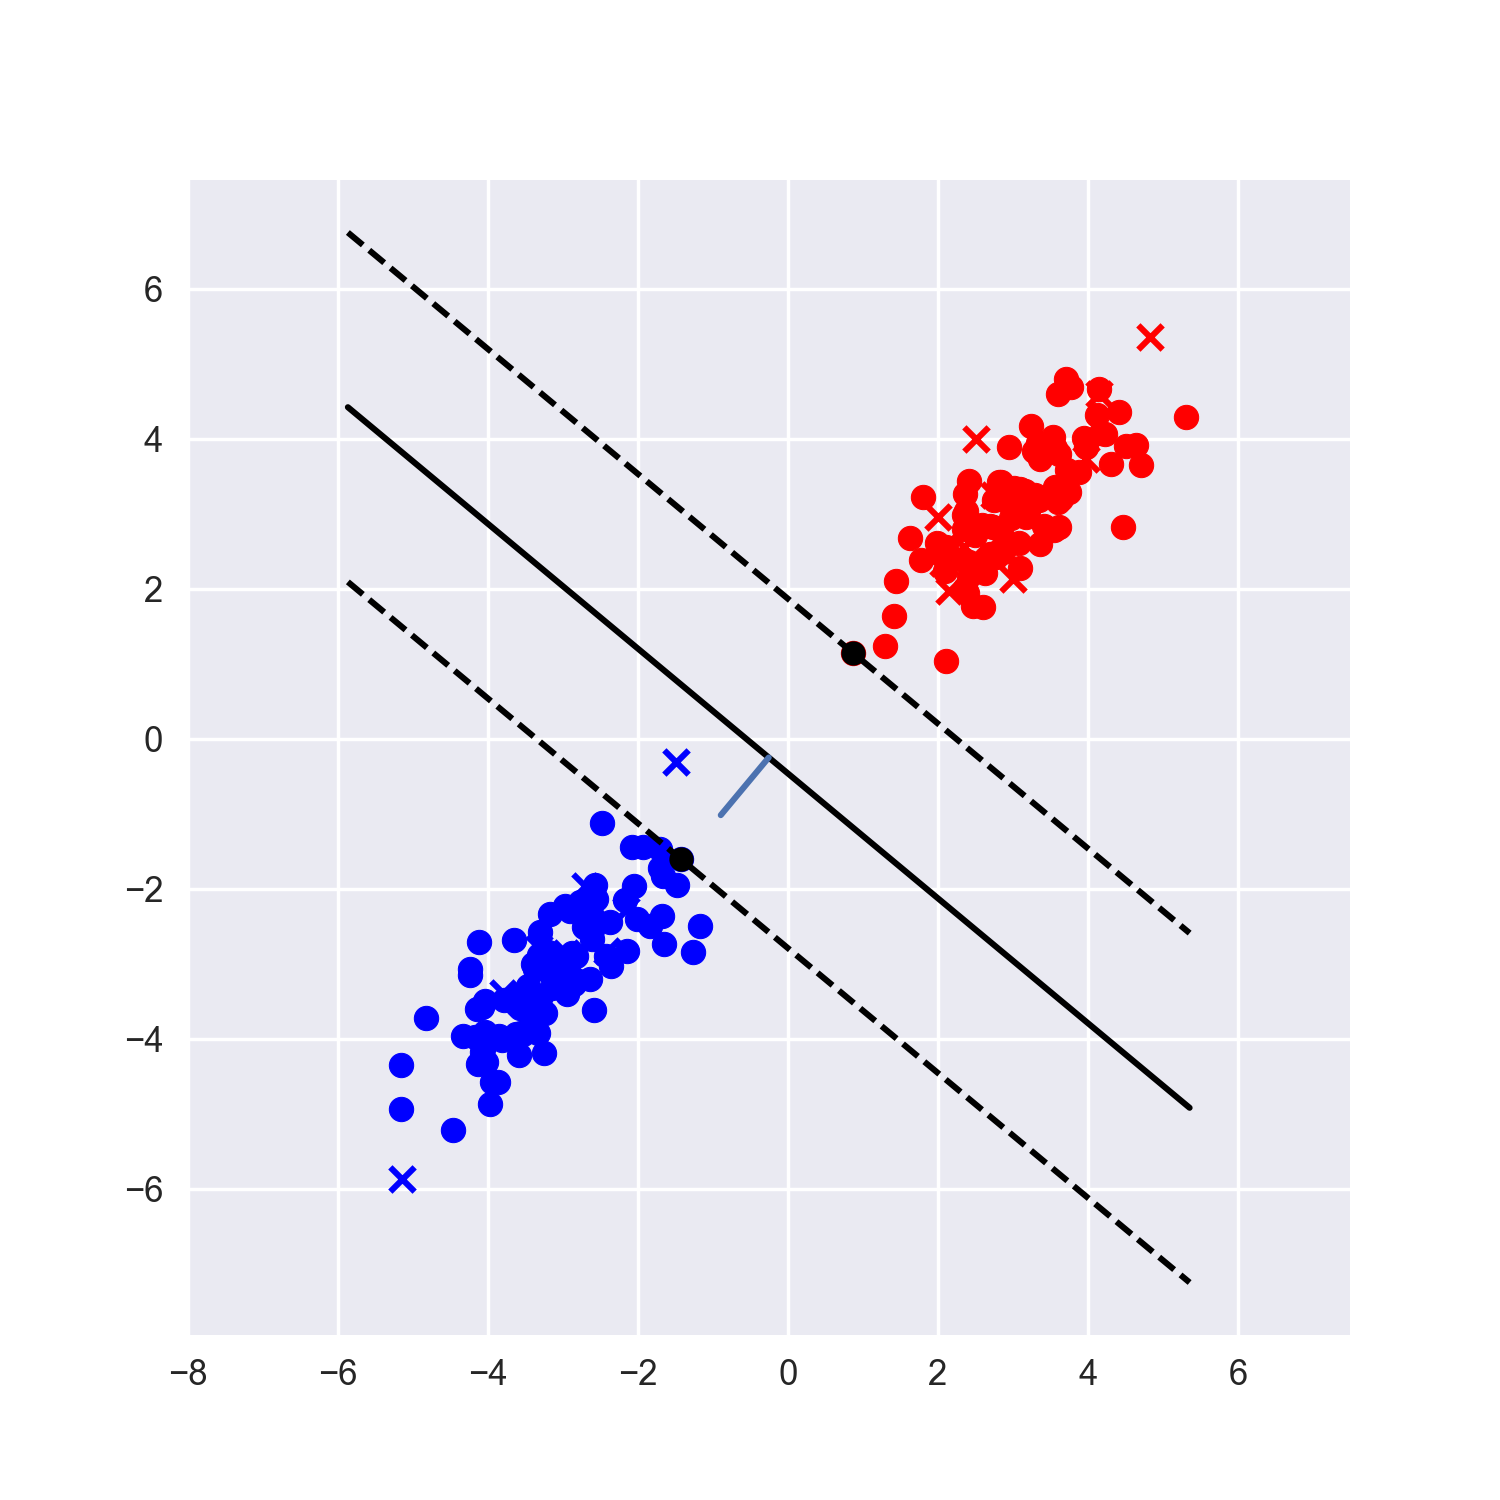

In [382]:
# generate linearly separable 2D training data
# data is centered around -3,-3 and 3,3
mean1 = np.array([-3, -3])
mean2 = np.array([3, 3])
cov = np.array([[0.8, 0.6], [0.6, 0.8]])
# get 100 points for the first class
X1 = np.random.multivariate_normal(mean1, cov, 100)
y1 = np.ones(len(X1))
# get 100 points for the second class
X2 = np.random.multivariate_normal(mean2, cov, 100)
y2 = np.ones(len(X2)) * -1

# split into training and testing data
Xtrain = np.vstack((X1[:90],X2[:90]))
ytrain = np.hstack((y1[:90],y2[:90]))
Xtest = np.vstack((X1[90:],X2[90:]))
ytest = np.hstack((y1[90:],y2[90:]))

# plot our data
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(X1[:90,0],X1[:90,1],None,'b','o')
plt.scatter(X1[90:,0],X1[90:,1],None,'b','x')
plt.scatter(X2[:90,0],X2[:90,1],None,'r','o')
plt.scatter(X2[90:,0],X2[90:,1],None,'r','x')

In [385]:
# let's train our SVM on the training data
nSamples, nFeatures = Xtrain.shape

# kernel matrix depending on the inner product
K = np.zeros((nSamples, nSamples))
for i in range(nSamples):
    for j in range(nSamples):
        K[i,j] = np.dot(Xtrain[i], Xtrain[j])

# now get everything into a format that qp can understand
P = cvxopt.matrix(np.outer(ytrain,ytrain) * K)
q = cvxopt.matrix(np.ones(nSamples) * -1)
A = cvxopt.matrix(ytrain, (1,nSamples))
b = cvxopt.matrix(0.0)
G = cvxopt.matrix(np.diag(np.ones(nSamples) * -1))
h = cvxopt.matrix(np.zeros(nSamples))  

# solve quadratic programming problem with proper constraints
solution = cvxopt.solvers.qp(P, q, G, h, A, b)

# the Langrange multipliers "a" are found by the solution 
a = np.ravel(solution['x'])

# now we find the support vectors 
# these are the entries of a that are non-zero, i.e., 
# we are looking for the non-zero lagrange multipliers
sv_ind = a > 1e-5
# get the values of the non-zero lagrange multipliers
a = a[sv_ind]
# these are the support vectors
sv = Xtrain[sv_ind]
# these are the classes of the suppport vectors
sv_y = ytrain[sv_ind]
print("found {:d} support vectors in {:d} data points".format(len(a), nSamples))

# calculate the weight vector
w = np.zeros(nFeatures)
for i in range(len(sv)):
    w += a[i] * sv_y[i] * sv[i]
        
# calculate the intercept - we take the first SV 
# and use the fact that yi*(w*x + b) = 1 for all SV! 
b = 1 / sv_y[0] - np.dot(w,sv[0])


# evaluate on training data
print("Training error rate on {:d} points: {:d}".format(len(ytrain),np.count_nonzero(np.sign(np.dot(Xtrain, w) + b)-ytrain)))

# now let's evaluate this on the test data
print("Testing error rate on {:d} points: {:d}".format(len(ytest),np.count_nonzero(np.sign(np.dot(Xtest, w) + b)-ytest)))

# this is the scikit SVM implementation - this includes a regularization term "C"
# in order to make this comparable we use a very high "C" value, which means LITTLE regularization
svc = SVC(kernel='linear',C=100).fit(Xtrain,ytrain)

print('weights from our implementation:',w)
print('weights from scikit implementation:',svc.coef_)


     pcost       dcost       gap    pres   dres
 0: -1.1034e+01 -1.8593e+01  5e+02  2e+01  2e+00
 1: -7.7596e+00 -1.2801e+00  3e+01  2e+00  1e-01
 2: -4.1519e-01 -2.2190e-01  1e+00  6e-02  5e-03
 3: -9.0766e-02 -1.8307e-01  9e-02  4e-16  1e-15
 4: -1.2685e-01 -1.5681e-01  3e-02  8e-17  6e-16
 5: -1.4933e-01 -1.5657e-01  7e-03  8e-17  7e-16
 6: -1.5590e-01 -1.5597e-01  8e-05  8e-17  7e-16
 7: -1.5597e-01 -1.5597e-01  8e-07  1e-16  7e-16
 8: -1.5597e-01 -1.5597e-01  8e-09  8e-17  8e-16
Optimal solution found.
found 2 support vectors in 180 data points
Training error rate on 180 points: 0
Testing error rate on 20 points: 0
weights from our implementation: [-0.35729172 -0.42927299]
weights from scikit implementation: [[-0.35729173 -0.429273  ]]


In [384]:
# plot support vectors
for i in range(len(sv)):
    plt.plot(sv[i,0],sv[i,1],'ko')

# plot separating hyperplane
# remember that w*x + b =0
# so, we fix an x-value, say x0, and therefore:
# w0*x0 + w1*y0 + b =0, then we can find y0
x0 = np.min(X1)
y0 = (-w[0] * x0 - b) / w[1]
x1 = np.max(X2)
y1 = (-w[0] * x1 - b) / w[1]
plt.plot([x0,x1],[y0,y1],'k')

# plot weight vector perpendicular to the hyperplane
wnorm = w/np.linalg.norm(w)
plt.plot([(x0+x1)/2,(x0+x1)/2+wnorm[0]],[(y0+y1)/2,(y0+y1)/2+wnorm[1]])
plt.axis('equal')

# plot margins
x0 = np.min(X1)
y0 = (-w[0] * x0 - b - 1) / w[1]
x1 = np.max(X2)
y1 = (-w[0] * x1 - b - 1) / w[1]
plt.plot([x0,x1],[y0,y1],'k--')

x0 = np.min(X1)
y0 = (-w[0] * x0 - b + 1) / w[1]
x1 = np.max(X2)
y1 = (-w[0] * x1 - b + 1) / w[1]
plt.plot([x0,x1],[y0,y1],'k--')

